# load data 

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import json
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score


In [2]:
dataframe = pd.concat([
    pd.read_csv("data/climate_data_54.csv"),
    pd.read_csv("data/climate_data_55.csv")
], ignore_index=True)
dataframe.head()

,datetime,city_name,lat,lon,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,rain,thunder,thunder_count
0,2022-10-09 18:00:00,54,4.99719,-72.7074,24.95,21.46,25.62,24.24,25.24,1010,81,1.57,90,0.0,99,0,0,0
1,2022-10-09 19:00:00,54,4.99719,-72.7074,24.61,22.11,25.37,23.83,25.14,1011,86,1.28,75,0.0,98,0,1,1
2,2022-10-09 20:00:00,54,4.99719,-72.7074,24.74,22.43,25.54,24.01,25.28,1013,87,1.18,64,0.0,99,0,0,0
3,2022-10-09 21:00:00,54,4.99719,-72.7074,23.76,22.20,24.57,22.96,24.29,1014,91,1.21,64,0.0,100,0,1,1
4,2022-10-09 22:00:00,54,4.99719,-72.7074,23.18,21.63,23.93,22.39,23.56,1014,91,0.73,23,0.0,98,0,1,2


In [3]:
dataframe.describe()

,city_name,lat,lon,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,rain,thunder,thunder_count
count,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000
mean,54.500000,5.115477,-72.673969,25.069404,20.938437,26.322247,24.451300,25.607355,1013.625608,79.201899,1.105853,201.949762,0.174930,76.508701,0.279291,0.123970,8.704714
std,0.500006,0.117589,0.032309,3.287519,1.752598,4.277070,3.385092,3.278416,2.768608,12.913318,0.653557,107.347281,0.598313,27.485862,0.448656,0.329551,89.328204
min,54.000000,4.997190,-72.707400,15.240000,12.700000,15.040000,14.410000,15.580000,1005.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,4.997190,-72.707400,22.550000,19.840000,23.170000,21.830000,23.100000,1012.000000,71.000000,0.620000,109.000000,0.000000,60.000000,0.000000,0.000000,0.000000
50%,54.500000,5.116820,-72.671750,24.590000,21.070000,25.260000,23.980000,25.140000,1014.000000,82.000000,0.970000,186.000000,0.000000,90.000000,0.000000,0.000000,0.000000
75%,55.000000,5.233060,-72.641700,27.370000,22.150000,29.627500,26.850000,27.890000,1016.000000,89.000000,1.450000,315.000000,0.130000,98.000000,1.000000,0.000000,0.000000
max,55.000000,5.233060,-72.641700,36.010000,29.860000,41.040000,35.430000,37.060000,1024.000000,100.000000,4.450000,360.000000,17.660000,100.000000,1.000000,1.000000,6213.000000


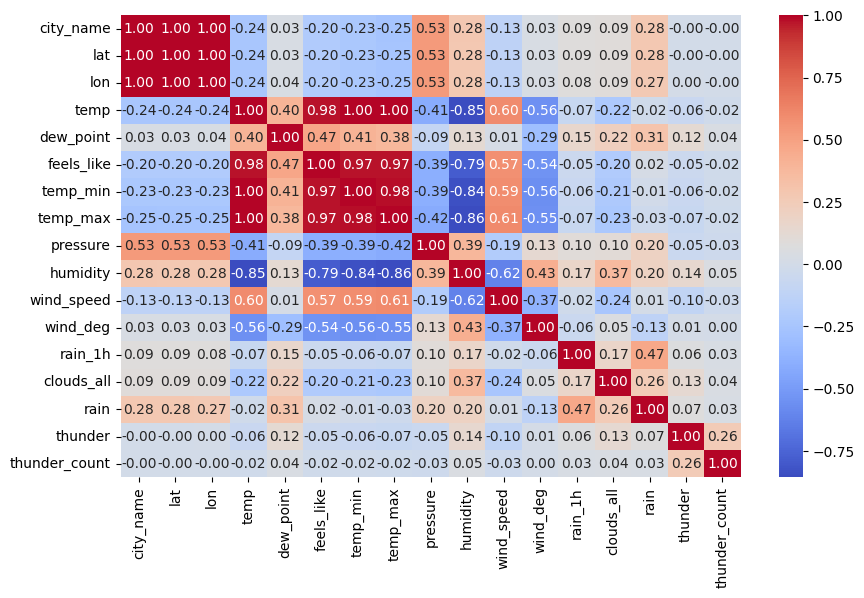

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = dataframe.drop('datetime', axis=1).corr()
plt.figure(figsize=(10, 6))
# Visualizar la matriz de correlación como un heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Mostrar el gráfico
plt.show()

# load best params

In [5]:
#load the best hyper params 
with open('scripts/best_params.json') as f:
    best = json.load(f)
best = best['best_params']

# preprocess

## outliers

In [6]:
def zscore_count(df, column):
    z = zscore(df[column])
    
    return df[z.abs() > 3][column]

## normalize and group by n steps

In [7]:
from scripts.preprocess import scale, ts_preprocess, balance

In [8]:
#string to datetime format
dataframe["datetime"] = pd.to_datetime(dataframe["datetime"])

#drop redundant features
dataframe_fs = dataframe.drop(['thunder_count', 'temp_min', 'temp_max', 'feels_like'], axis=1)

#select features tu scale
scale_cols = list(dataframe_fs.columns)
scale_cols = [x for x in scale_cols if x not in ['thunder', 'city_name', 'datetime']]

#scale feature with standard scaler
dataframe_fs[scale_cols] = scale(dataframe_fs[scale_cols], 'standard')

#sort by city and datetime and group by city
df_sorted = dataframe_fs.sort_values(by=["city_name", "datetime"])
groups = df_sorted.groupby('city_name')

In [9]:
#process data to obtain shape: (N, seq_length, N_columns)
#and balance the data
X_ts = []
y_ts = []
X_sc = []
y_sc = []

n_steps = best.pop('n_steps')

for key, group in groups:

    X = group.drop(['thunder', 'datetime', 'city_name'], axis=1)
    y = group['thunder']
    
    X = X.to_numpy()
    y = y.to_numpy()

    #without timesteps
    X_, y_ = balance(X, y)
    X_sc.append(X_)
    y_sc.append(y_)

    #with timesteps
    X, y = ts_preprocess(X, y, n_steps)
    X, y = balance(X, y)
    X_ts.append(X)
    y_ts.append(y)

X_ts = np.concatenate(X_ts, axis=0)
y_ts = np.concatenate(y_ts, axis=0)
X_sc = np.concatenate(X_sc, axis=0)
y_sc = np.concatenate(y_sc, axis=0)

In [10]:
X_ts.shape, y_ts.shape, X_sc.shape, y_sc.shape

((9672, 31, 11), (9672,), (9688, 11), (9688,))

In [11]:
(y_ts == 1).sum(), (y_ts == 0).sum()

(np.int64(4836), np.int64(4836))

# Train test model

In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sc, y_sc, test_size=0.2, random_state=42)

# Crear el modelo RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir en los datos de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"f1: {f1:.4f}, accuracy: {accuracy:.4f}, recall: {recall:.4f}, precision: {precision:.4f}")
# print(y_test[:100])
# print(y_pred[:100])

f1: 0.6844, accuracy: 0.6703, recall: 0.7115, precision: 0.6594


# LSTM

## model

In [ ]:
from scripts.train import lstm_torch_cv, lstm_torch_train

## test lstm

In [15]:
result_dict = lstm_torch_cv(X_ts, y_ts)

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | lstm         | LSTM    | 14.2 K | train
1 | hidden2label | Linear  | 33     | train
2 | criterion    | BCELoss | 0      | train
-------------------------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Epoch 699: 100%|██████████| 57/57 [00:00<00:00, 69.75it/s, v_num=86]

`Trainer.fit` stopped: `max_epochs=700` reached.


Epoch 699: 100%|██████████| 57/57 [00:00<00:00, 69.33it/s, v_num=86]


Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | lstm         | LSTM    | 14.2 K | train
1 | hidden2label | Linear  | 33     | train
2 | criterion    | BCELoss | 0      | train
-------------------------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Epoch 699: 100%|██████████| 57/57 [00:00<00:00, 90.95it/s, v_num=87] 

`Trainer.fit` stopped: `max_epochs=700` reached.


Epoch 699: 100%|██████████| 57/57 [00:00<00:00, 90.06it/s, v_num=87]


Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | lstm         | LSTM    | 14.2 K | train
1 | hidden2label | Linear  | 33     | train
2 | criterion    | BCELoss | 0      | train
-------------------------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Epoch 699: 100%|██████████| 57/57 [00:00<00:00, 69.89it/s, v_num=88]

`Trainer.fit` stopped: `max_epochs=700` reached.


Epoch 699: 100%|██████████| 57/57 [00:00<00:00, 69.33it/s, v_num=88]


Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | lstm         | LSTM    | 14.2 K | train
1 | hidden2label | Linear  | 33     | train
2 | criterion    | BCELoss | 0      | train
-------------------------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Epoch 699: 100%|██████████| 57/57 [00:00<00:00, 69.76it/s, v_num=89]

`Trainer.fit` stopped: `max_epochs=700` reached.


Epoch 699: 100%|██████████| 57/57 [00:00<00:00, 69.21it/s, v_num=89]
accuracies [0.7861869313482217, 0.7758478081058726, 0.7890818858560794, 0.7894954507857733]
f1_scores [np.float64(0.7929515418502202), np.float64(0.7847498014297061), np.float64(0.796812749003984), np.float64(0.7977751291219706)]
precisions [np.float64(0.7686335403726708), np.float64(0.7547746371275783), np.float64(0.7686395080707148), np.float64(0.7675840978593272)]
recalls [np.float64(0.8188585607940446), np.float64(0.8172043010752689), np.float64(0.8271298593879239), np.float64(0.8304383788254756)]
aucs [np.float64(0.7861869313482216), np.float64(0.7758478081058727), np.float64(0.7890818858560794), np.float64(0.7894954507857733)]
optimal_thresholds [0.5, 0.5, 0.5, 0.5]
accuracy mean 0.7851530190239867
f1_scores mean 0.7930723053514702
precisions mean 0.7649079458575727
recalls mean 0.8234077750206782
aucs mean 0.7851530190239867
optimal_thresholds mean 0.5


In [13]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_ts, y_ts, test_size=0.2, random_state=100)

result, cm = lstm_torch_train(X_train, X_test, y_train, y_test, cf_mt=True)

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-02 17:35:03.381012: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 17:35:03.381801: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 17:35:03.385118: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 17:35:03.392020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746225303.406743   12420 cuda_dnn.cc:8310] Unable to register cuDNN factory:

Epoch 699: 100%|██████████| 61/61 [00:00<00:00, 61.55it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=700` reached.


Epoch 699: 100%|██████████| 61/61 [00:00<00:00, 61.09it/s, v_num=1]


In [14]:
cm

array([[734, 253],
       [159, 789]])

## test cnn lstm

In [ ]:
result_dict = lstm_torch_cv(X_ts, y_ts, epochs=100, model_name='cnn_lstm')

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-28 18:30:15.249334: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 18:30:15.249847: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 18:30:15.252196: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 18:30:15.259590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin

Epoch 99: 100%|██████████| 57/57 [00:01<00:00, 29.72it/s, v_num=43]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 57/57 [00:01<00:00, 29.59it/s, v_num=43]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | cnn       | Sequential | 130 K  | train
1 | lstm      | LSTM       | 45.6 K | train
2 | fc        | Linear     | 33     | train
3 | criterion | BCELoss    | 0      | train
-------------------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.705     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Epoch 99: 100%|██████████| 57/57 [00:02<00:00, 25.80it/s, v_num=44]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 57/57 [00:02<00:00, 25.69it/s, v_num=44]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | cnn       | Sequential | 130 K  | train
1 | lstm      | LSTM       | 45.6 K | train
2 | fc        | Linear     | 33     | train
3 | criterion | BCELoss    | 0      | train
-------------------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.705     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Epoch 99: 100%|██████████| 57/57 [00:02<00:00, 22.05it/s, v_num=45]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 57/57 [00:02<00:00, 21.97it/s, v_num=45]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | cnn       | Sequential | 130 K  | train
1 | lstm      | LSTM       | 45.6 K | train
2 | fc        | Linear     | 33     | train
3 | criterion | BCELoss    | 0      | train
-------------------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.705     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Epoch 99: 100%|██████████| 57/57 [00:02<00:00, 23.13it/s, v_num=46]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 57/57 [00:02<00:00, 23.00it/s, v_num=46]
accuracies [0.7770885028949545, 0.7655086848635235, 0.8006617038875103, 0.7754342431761787]
f1_scores [np.float64(0.7841409691629956), np.float64(0.7688544639217285), np.float64(0.803265306122449), np.float64(0.7832335329341318)]
precisions [np.float64(0.7600931677018633), np.float64(0.7580385852090032), np.float64(0.7929089443996776), np.float64(0.7569444444444444)]
recalls [np.float64(0.8097601323407775), np.float64(0.7799834574028123), np.float64(0.8138957816377171), np.float64(0.8114143920595533)]
aucs [np.float64(0.7770885028949543), np.float64(0.7655086848635235), np.float64(0.8006617038875103), np.float64(0.7754342431761786)]
optimal_thresholds [0.5, 0.5, 0.5, 0.5]
accuracy mean 0.7796732837055418
f1_scores mean 0.7848735680353263
precisions mean 0.7669962854387471
recalls mean 0.8037634408602151
aucs mean 0.7796732837055417
optimal_thresholds mean 0.5


# hyperparameter tuning

In [ ]:
import optuna

In [ ]:
def objective(trial):
    #hyperparameters
    #epochs = trial.suggest_int('epochs', 80, 700)
    epochs =1
    hidden_size = trial.suggest_int('hidden_size', 25, 50)
    batch_size = trial.suggest_int('batch_size', 100, 512)
    model_name = trial.suggest_categorical('model_name', ['lstm', 'cnn_lstm'])
    num_layers = trial.suggest_int('num_layers', 1, 5)
    dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)
    kernel_size = trial.suggest_int('kernel_size', 2, 4)
    num_cnn = trial.suggest_int('num_cnn', 1, 6)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    
    result_dict = lstm_torch_cv(X_ts, y_ts, epochs = epochs, hidden_size = hidden_size, batch_size=batch_size, model_name = model_name, num_layers=num_layers, dropout = dropout, kernel_size = kernel_size, num_cnn = num_cnn, lr =lr)

    return result_dict['f1_scores mean']

In [68]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

best_params = study.best_params
best_score = study.best_value

best_params_with_score = {
    "best_params": best_params,
    "best_score": best_score
}

with open("best_params.json", "w") as f:
    json.dump(best_params_with_score, f, indent=4)

print(f"Mejores parámetros guardados en 'best_params.json': {best_params_with_score}")

[I 2025-04-28 20:19:02,476] A new study created in memory with name: no-name-97581964-bec7-4910-a854-0f1717e87f05
Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | lstm         | LSTM    | 17.7 K | train
1 | hidden2label | Linear  | 37     | train
2 | criterion    | BCELoss | 0      | train
-------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'tra

Epoch 0: 100%|██████████| 49/49 [00:00<00:00, 77.73it/s, v_num=75]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 49/49 [00:00<00:00, 77.28it/s, v_num=75]


Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | lstm         | LSTM    | 17.7 K | train
1 | hidden2label | Linear  | 37     | train
2 | criterion    | BCELoss | 0      | train
-------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Epoch 0: 100%|██████████| 49/49 [00:00<00:00, 81.48it/s, v_num=76]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 49/49 [00:00<00:00, 80.82it/s, v_num=76]


Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | lstm         | LSTM    | 17.7 K | train
1 | hidden2label | Linear  | 37     | train
2 | criterion    | BCELoss | 0      | train
-------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Epoch 0: 100%|██████████| 49/49 [00:00<00:00, 78.81it/s, v_num=77]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 49/49 [00:00<00:00, 78.08it/s, v_num=77]


Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | lstm         | LSTM    | 17.7 K | train
1 | hidden2label | Linear  | 37     | train
2 | criterion    | BCELoss | 0      | train
-------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Epoch 0: 100%|██████████| 49/49 [00:00<00:00, 79.29it/s, v_num=78]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 49/49 [00:00<00:00, 78.82it/s, v_num=78]


[I 2025-04-28 20:19:05,259] Trial 0 finished with value: 0.6932992508360349 and parameters: {'hidden_size': 36, 'batch_size': 151, 'model_name': 'lstm', 'num_layers': 2, 'dropout': 0.5, 'kernel_size': 4, 'num_cnn': 4, 'lr': 0.0017325066604411325}. Best is trial 0 with value: 0.6932992508360349.


accuracies [0.6563275434243176, 0.6381306865177833, 0.6476426799007444, 0.6550868486352357]
f1_scores [np.float64(0.6994575045207957), np.float64(0.6823956442831216), np.float64(0.6928622927180966), np.float64(0.6984815618221258)]
precisions [np.float64(0.62146529562982), np.float64(0.6080206985769728), np.float64(0.6140575079872205), np.float64(0.6204238921001927)]
recalls [np.float64(0.7998345740281224), np.float64(0.7775020678246485), np.float64(0.7948717948717948), np.float64(0.7990074441687345)]
aucs [np.float64(0.6563275434243176), np.float64(0.6381306865177834), np.float64(0.6476426799007443), np.float64(0.6550868486352357)]
optimal_thresholds [0.5, 0.5, 0.5, 0.5]
accuracy mean 0.6492969396195203
f1_scores mean 0.6932992508360349
precisions mean 0.6159918485735515
recalls mean 0.7928039702233249
aucs mean 0.6492969396195203
optimal_thresholds mean 0.5
Mejores parámetros guardados en 'best_params.json': {'best_params': {'hidden_size': 36, 'batch_size': 151, 'model_name': 'lstm', 

# train test with best params

## cv

In [ ]:
result_dict = lstm_torch_cv(**best, X=X_ts, y=y_ts)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-29 09:17:13.092917: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 09:17:13.093443: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 09:17:13.096582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 09:17:13.103783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin

Epoch 619: 100%|██████████| 31/31 [00:02<00:00, 14.01it/s, v_num=81]

`Trainer.fit` stopped: `max_epochs=620` reached.


Epoch 619: 100%|██████████| 31/31 [00:02<00:00, 13.91it/s, v_num=81]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | cnn       | Sequential | 32.0 K | train
1 | lstm      | LSTM       | 109 K  | train
2 | fc        | Linear     | 49     | train
3 | criterion | BCELoss    | 0      | train
-------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.566     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Epoch 619: 100%|██████████| 31/31 [00:02<00:00, 13.94it/s, v_num=82]

`Trainer.fit` stopped: `max_epochs=620` reached.


Epoch 619: 100%|██████████| 31/31 [00:02<00:00, 13.87it/s, v_num=82]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | cnn       | Sequential | 32.0 K | train
1 | lstm      | LSTM       | 109 K  | train
2 | fc        | Linear     | 49     | train
3 | criterion | BCELoss    | 0      | train
-------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.566     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Epoch 619: 100%|██████████| 31/31 [00:02<00:00, 13.96it/s, v_num=83]

`Trainer.fit` stopped: `max_epochs=620` reached.


Epoch 619: 100%|██████████| 31/31 [00:02<00:00, 13.86it/s, v_num=83]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | cnn       | Sequential | 32.0 K | train
1 | lstm      | LSTM       | 109 K  | train
2 | fc        | Linear     | 49     | train
3 | criterion | BCELoss    | 0      | train
-------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.566     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Epoch 619: 100%|██████████| 31/31 [00:02<00:00, 12.60it/s, v_num=84]

`Trainer.fit` stopped: `max_epochs=620` reached.


Epoch 619: 100%|██████████| 31/31 [00:02<00:00, 12.54it/s, v_num=84]
accuracies [0.7841191066997518, 0.7907361455748553, 0.7932175351530191, 0.7932175351530191]
f1_scores [np.float64(0.7952941176470588), np.float64(0.8003157063930545), np.float64(0.8011137629276054), np.float64(0.8009554140127388)]
precisions [np.float64(0.756152125279642), np.float64(0.7652830188679245), np.float64(0.7716475095785441), np.float64(0.7720644666155027)]
recalls [np.float64(0.8387096774193549), np.float64(0.8387096774193549), np.float64(0.8329197684036393), np.float64(0.8320926385442514)]
aucs [np.float64(0.7841191066997519), np.float64(0.7907361455748553), np.float64(0.7932175351530191), np.float64(0.7932175351530191)]
optimal_thresholds [0.5, 0.5, 0.5, 0.5]
accuracy mean 0.7903225806451613
f1_scores mean 0.7994197502451144
precisions mean 0.7662867800854033
recalls mean 0.8356079404466501
aucs mean 0.7903225806451614
optimal_thresholds mean 0.5


## train test

In [15]:
result, cm = lstm_torch_train(**best, X_train=X_train, X_val=X_test, y_train=y_train, y_val=y_test, cf_mt=True)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | cnn       | Sequential | 32.0 K | train
1 | lstm      | LSTM       | 109 K  | train
2 | fc        | Linear     | 49     | train
3 | criterion | BCELoss    | 0      | train
-------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.566     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/gyuhee/Documents/bioinformatics/atlas/micro_atlas/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Epoch 619: 100%|██████████| 34/34 [00:02<00:00, 12.64it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=620` reached.


Epoch 619: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s, v_num=2]


In [16]:
cm

array([[749, 238],
       [164, 784]])